

<h1 style="color: orange;">PRÁCTICA 5</h1>



In [3]:
%reset

import scipy.io.wavfile as wf
import scalib as sc
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from matplotlib.gridspec import GridSpec
from scipy import signal
from scalib import bode
import numpy as np


In [4]:

def encoderPCM(data, dataRange, b):
    if b > 0:
        # Creamos un cuantificador uniforme de tipo "midtread" con b bits y el rango de entrada especificado
        qtz = sc.UniformSQ(b, dataRange)
        # Aplicamos el cuantificador a la señal para obtener los identificadores de nivel (índices de cuantificación)
        # Los índices que indican en qué nivel de cuantificación ha caído cada muestra de la señal
        ids = qtz.encode(data)
        # Creamos un codificador de longitud fija (b bits por identificador)
        coder = sc.FixedLengthCoder(b)
        # Codificamos la secuencia de identificadores a una secuencia binaria
        code = coder.encode(ids)
        # Devolvemos la secuencia binaria resultante
    else: code = np.array([], dtype=int)
    return code

def encoderAPCM(data, wlen, dataRange, b, bg):
    code = []
    maxGain = dataRange[1]
    gainRange = (0, maxGain)
    
    for k in range(0,len(data),wlen):
        w = data[k : k + wlen] # ventana , w->window
        gain = max(abs(w)) # la ganancia es el mayoy de los valores absolutos
        w = w/gain #Aplica la ganancia a los datos actuales
        cw = encoderPCM(w,dataRange,b) # # Cuantifica (mapeo del codifcador) con b bits los datos yCodica con b bits los datos cuanticados
        cg = encoderPCM(gain,gainRange, bg) # Cuantica (mapeo del codicador) con bg bits la ganancia y Codica con bg bits la ganancia cuanticada
        code = np.concatenate((code, cg, cw)) # Acumula los datos de la ventana actual(al poner dos parentesis ni da error)
    
    return code

def decoderPCM(code, dataRange, b):
    # Creamos un decodificador de longitud fija que sabe leer bloques de b bits
    if b > 0 :
        decoder = sc.FixedLengthCoder(b)
        # Decodificamos la secuencia binaria para obtener los identificadores de nivel "originales"
        ids = decoder.decode(code)
        # Creamos el mismo cuantificador uniforme usado en la codificación (tipo midtread, con b bits y el mismo rango)
        qtz = sc.UniformSQ(b, dataRange)
        # Reconstruimos ( mapeo decodificador) los valores cuantificados a partir de los identificadores
        data = qtz.decode(ids)
        # Devolvemos la señal cuantificada reconstruida
    else: data = np.array([], dtype=int)
    return data

def decoderAPCM(code, wlen, dataRange, b, bg):
    data = []
    maxGain = dataRange[1]
    gainRange = (0, maxGain)
    

    
    for k in range(0,len(code),bg + wlen * b):
        cg = code[k:k+bg] # Recupera la secuencia de bits correspondiente a la ganancia
        cw = code[k+bg:k+bg+wlen*b]
        gain = decoderPCM(cg,gainRange, bg)  # Decodifica la ganancia y la cuantifica(mapeo del descodificador)
        w = decoderPCM(cw,dataRange,b) # Decodifica los datos y los cuantifica (mapeo del descodificador)
        w = w*gain # Aplica la ganancia a los datos actuales
        data = np.concatenate((data, w))  # Acumula los datos de la ventana actual
    
    return data

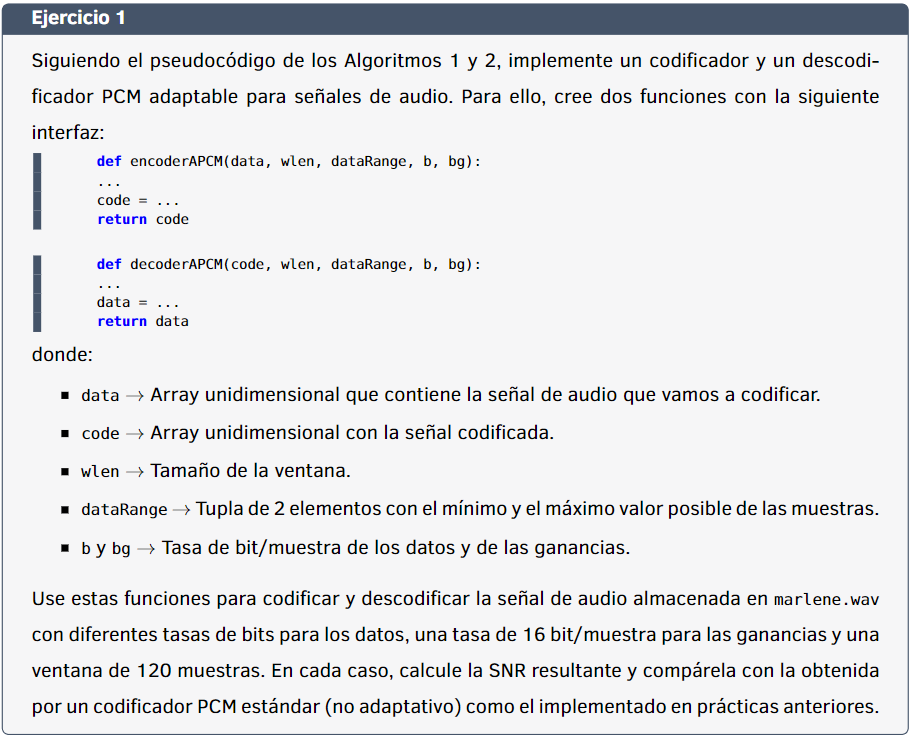

 Bits |    SNR PCM |   SNR APCM
------------------------------
    2 |      -0.12 |       9.75
    4 |      12.56 |      21.73
    6 |      25.04 |      33.77
    8 |      37.57 |      45.80


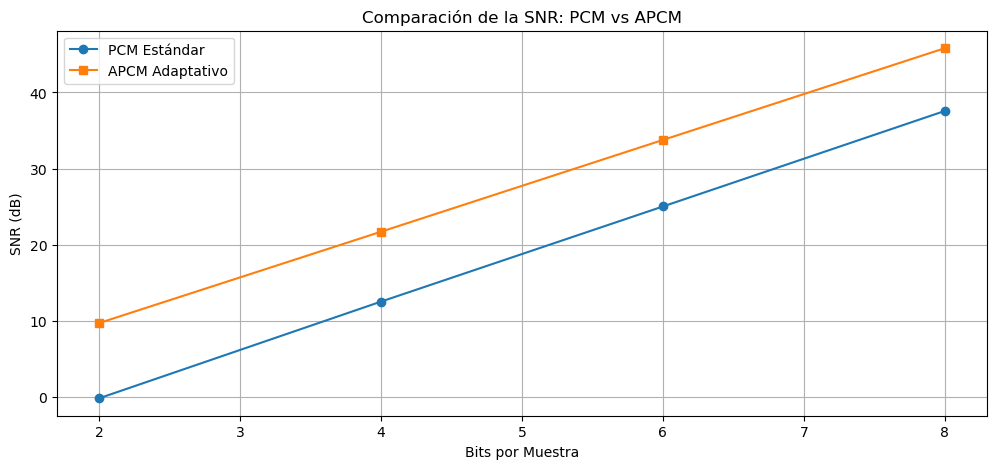

In [5]:

# Parámetros
wlen = 120  # Tamaño de la ventana
bg = 16     # Bits para la ganancia
b_values = [2, 4, 6, 8]  # Bits para los datos (diferentes tasas)

# Leer la señal
fs, s = wf.read('marlene.wav')
s = s.astype(float)
s = s / np.max(np.abs(s))  # Normalizar a [-1,1]
dataRange = [-1, 1]

# Resultados
snr_pcm = []
snr_apcm = []

for b in b_values:
    # Codificación y decodificación estándar PCM
    code_pcm = encoderPCM(s, dataRange, b)
    s_rec_pcm = decoderPCM(code_pcm, dataRange, b)
    snr_pcm.append(sc.snr(s, s_rec_pcm))
    
    # Codificación y decodificación adaptativa APCM
    code_apcm = encoderAPCM(s, wlen, dataRange, b, bg)
    s_rec_apcm = decoderAPCM(code_apcm, wlen, dataRange, b, bg)
    snr_apcm.append(sc.snr(s, s_rec_apcm))

# Mostrar resultados
print(f"{'Bits':>5} | {'SNR PCM':>10} | {'SNR APCM':>10}")
print("-"*30)
for bits, snr1, snr2 in zip(b_values, snr_pcm, snr_apcm):
    print(f"{bits:5} | {snr1:10.2f} | {snr2:10.2f}")
    


# Crear la gráfica
plt.figure(figsize=(12,5))
plt.plot(b_values, snr_pcm, marker='o', label='PCM Estándar')
plt.plot(b_values, snr_apcm, marker='s', label='APCM Adaptativo')
plt.xlabel('Bits por Muestra')
plt.ylabel('SNR (dB)')
plt.title('Comparación de la SNR: PCM vs APCM')
plt.grid(True)
plt.legend()
plt.show()


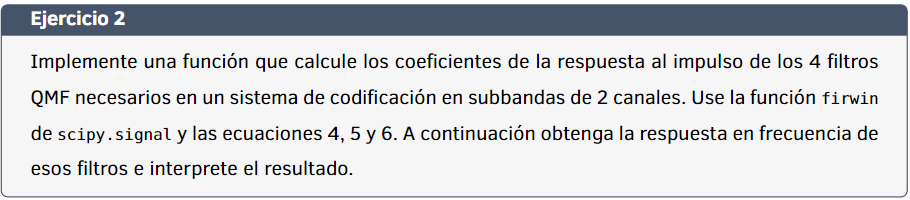

z:\OneDrive\OneDrive - UNIVERSIDAD DE GRANADA\S.Telecom\HUB\SCA\P4\scalib.py:818: RuntimeWarning: divide by zero encountered in log10
  mag = 20 * np.log10(np.abs(H))


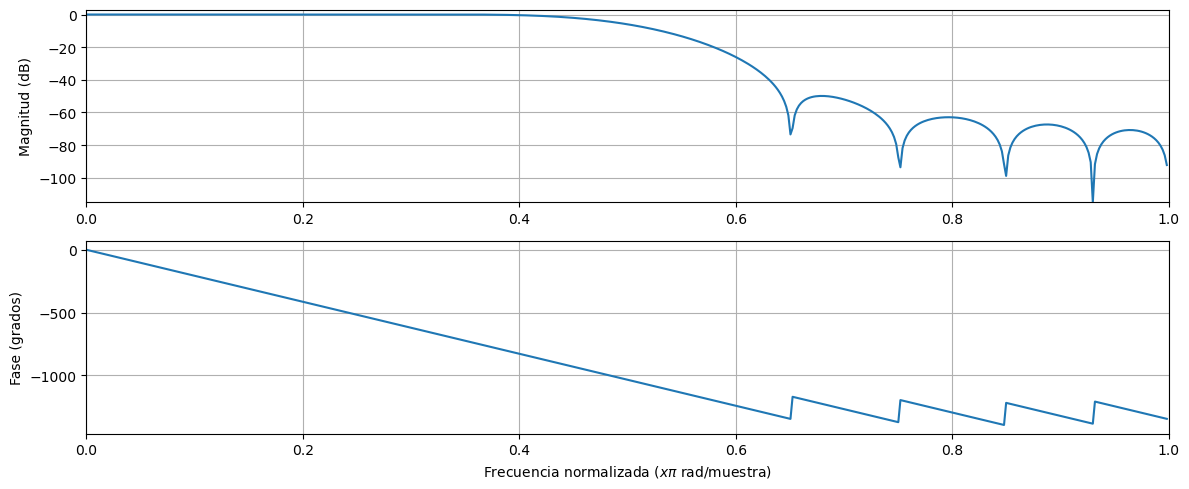

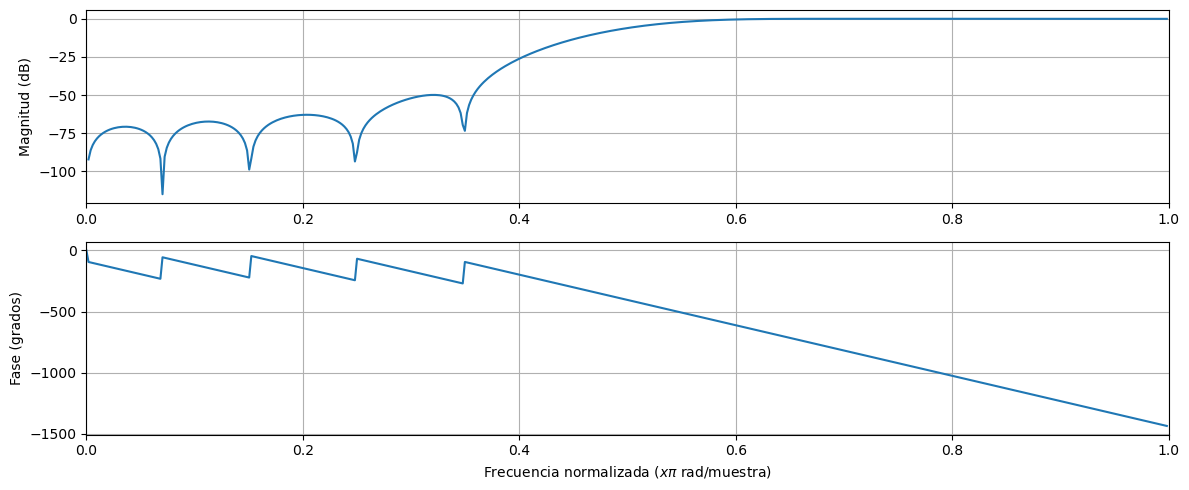

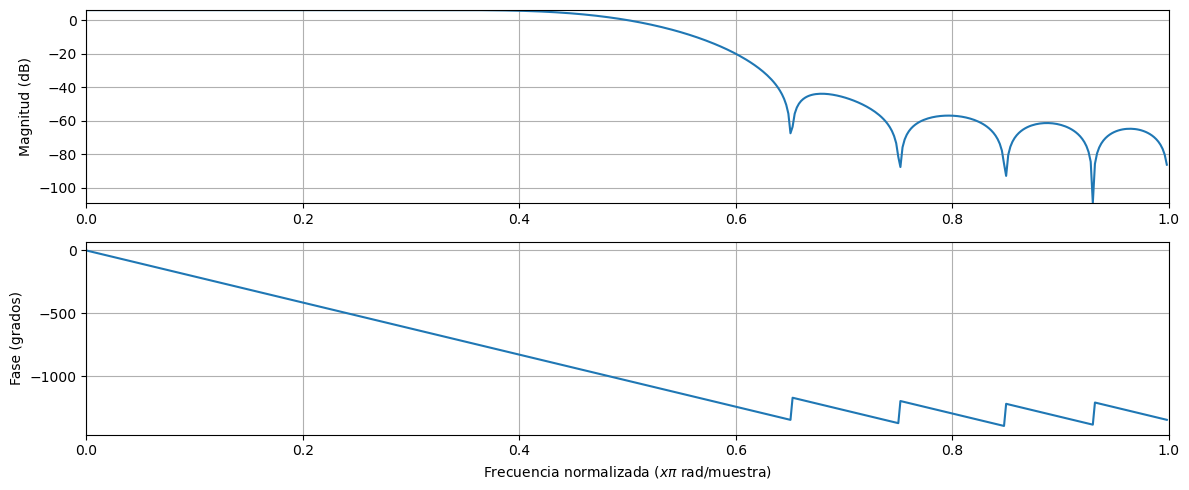

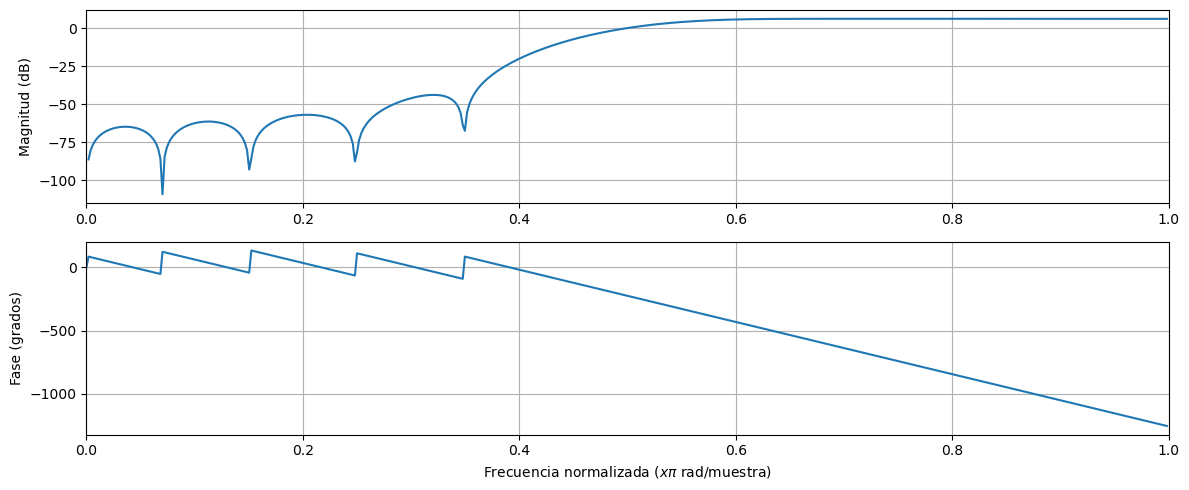

In [6]:

def QMF_filters(length, fc):

    # FIR de paso bajo con ventana de Hamming
    h1 = signal.firwin(length, fc, window='hamming')
    
    # Generar el signo alternante (-1)^k vectorizado
    signs = (-1) ** np.arange(length)
    
    # Filtro de paso alto QMF
    h2 = h1 * signs

    # Ganancias k1,k2 según ecuaciones
    k1 =  2 * h1
    k2 = -2 * h2

    return h1, h2, k1, k2


length = 24
fc = 0.5 # pi/2 [rad/muestra]
fc_sup = fc * 1.08  # 8% superior

# Calculamos los coeficientes de los filtros QMF
h1, h2, k1, k2 = QMF_filters(length, fc)
h1_sup, h2_sup, k1_sup, k2_sup = QMF_filters(length, fc_sup)

bode(h1)
bode(h2)
bode(k1)
bode(k2)

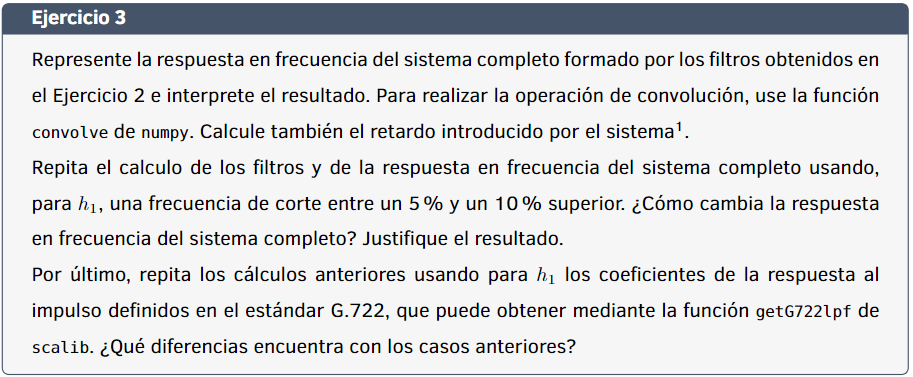

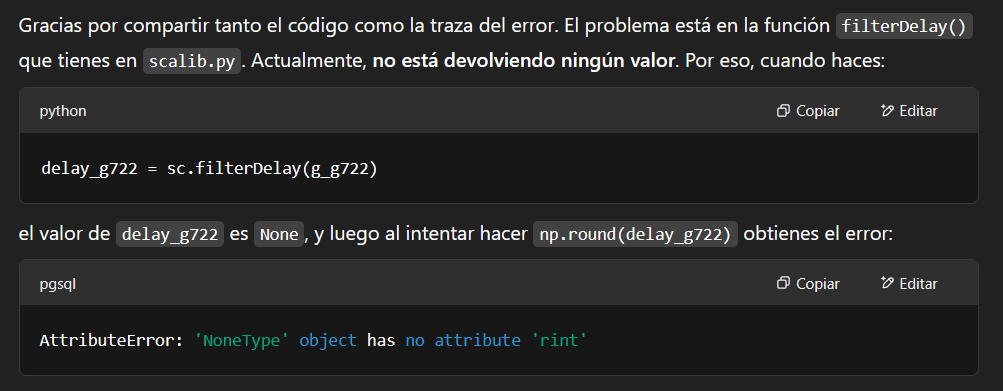

Retardo de grupo: 23.0 muestras
Retardo de grupo al aumentar un 8% la frecuencia de corte: 23.0 muestras
Retardo G.722 QMF: 23.0 muestras


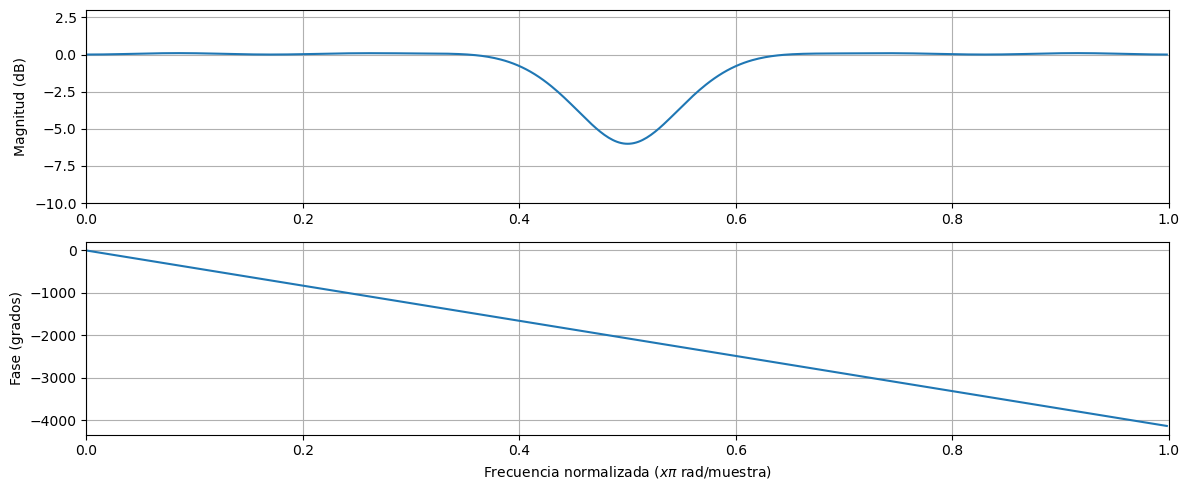

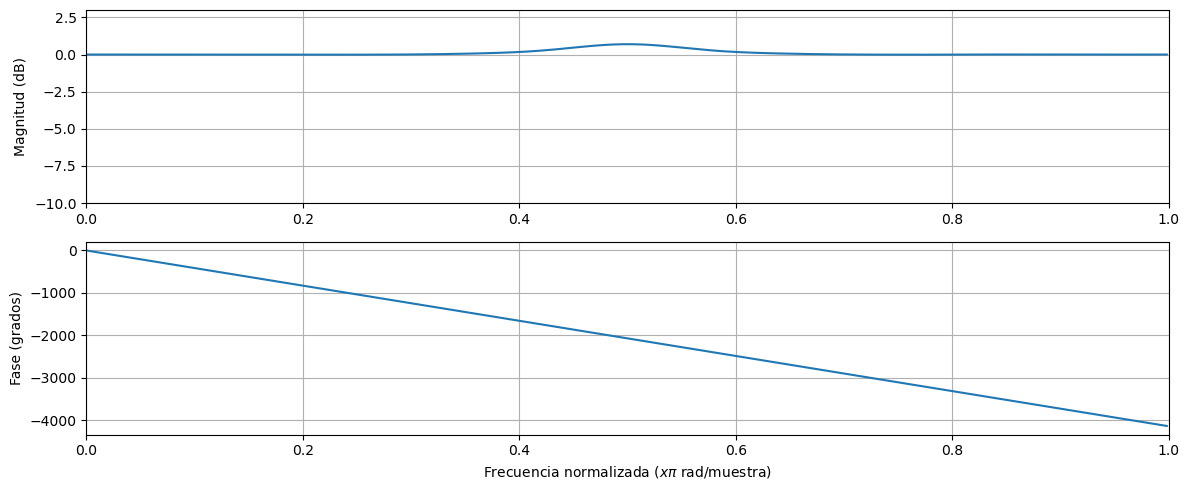

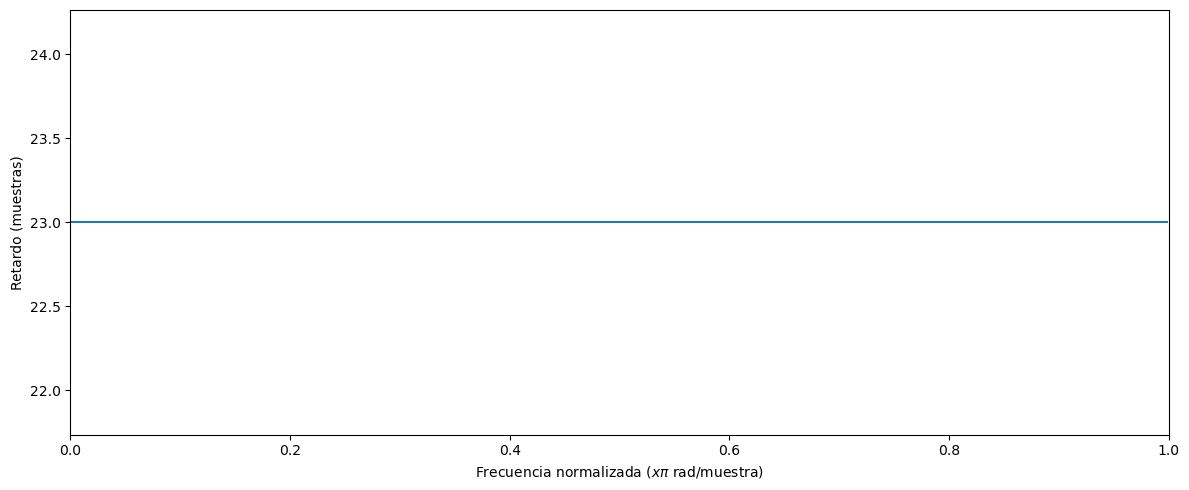

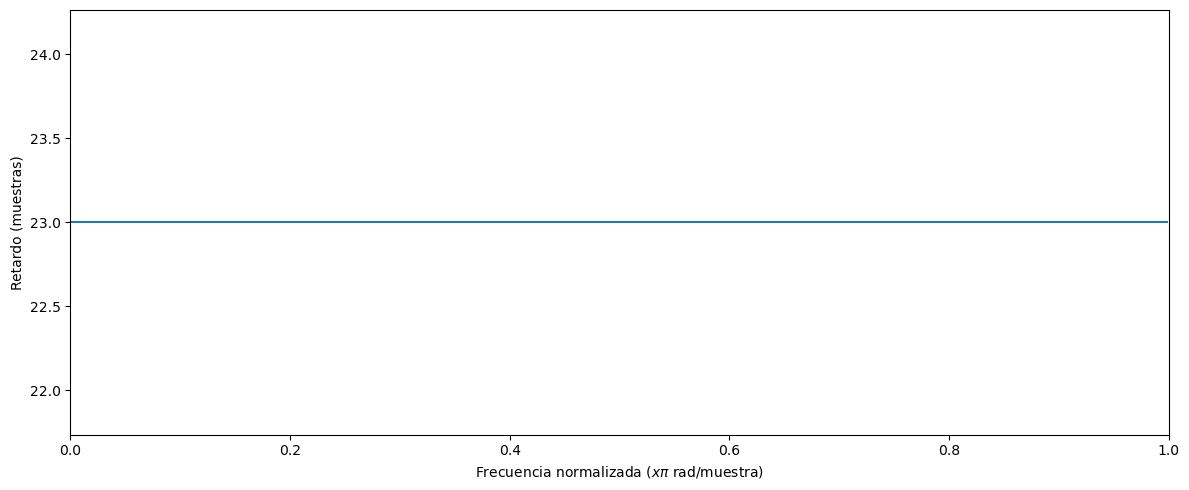

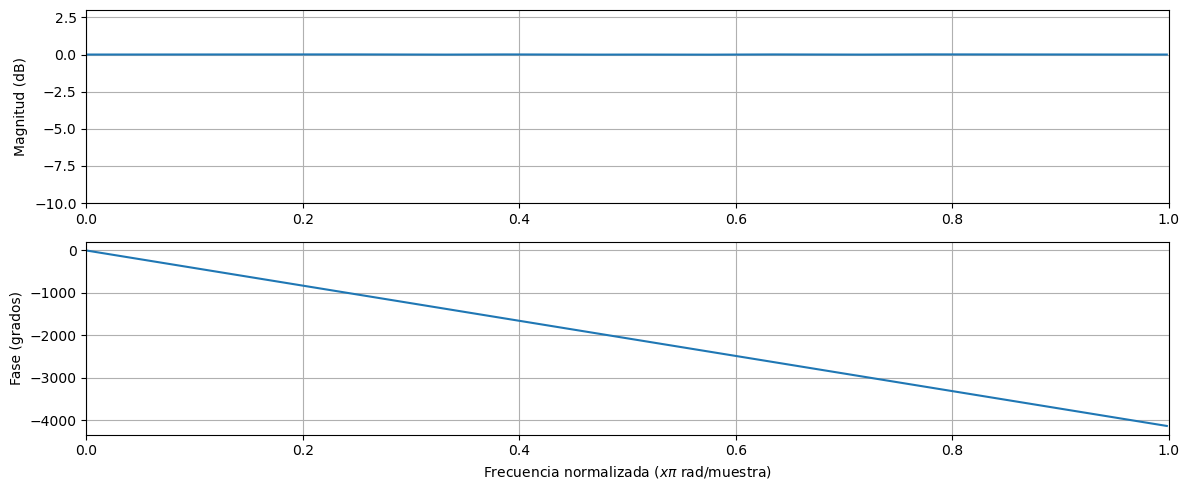

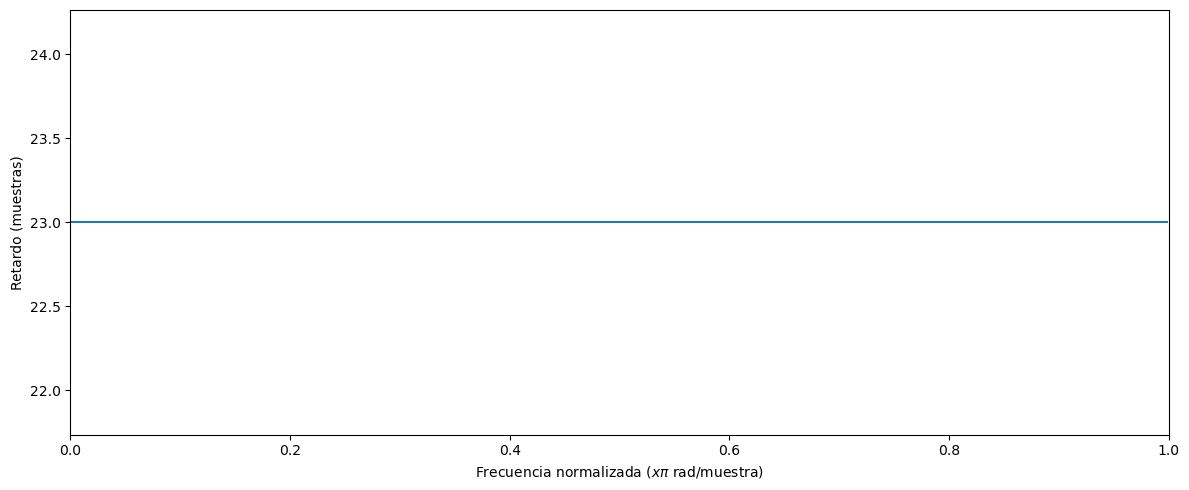

In [7]:
import importlib
import scalib as sc
importlib.reload(sc)

def impulse_response(h_1, h_2, k_1, k_2):
    """
    Calcula la respuesta al impulso combinada de 4 filtros de filtros QMF según la ecuación:
        g[n] = ½ ( h1[n] * k1[n] + h2[n] * k2[n] )/2
   """
    # convolución de cada rama
    conv_1  = np.convolve(h_1,  k_1,  mode='full')
    conv_2 = np.convolve(h_2, k_2, mode='full')
    g = (conv_1 + conv_2)/2
    return g

g = impulse_response(h1, h2, k1, k2  )           
g_sup = impulse_response(h1_sup, h2_sup, k1_sup, k2_sup)

bode(g)
bode(g_sup)

delay = sc.filterDelay(g) # Retardo introducido por el sistema
delay_sup = sc.filterDelay(g_sup) # Retardo introducido por el sistema

print(f"Retardo de grupo: {delay} muestras")
print(f"Retardo de grupo al aumentar un 8% la frecuencia de corte: {delay_sup} muestras")



# ——— Mismo proceso usando el LPF de scalib (G.722) ———


h1_g722 = sc.getG722lpf() # Obtenemos el filtropaso baja de análisis

# Genera el FIR de paso alto por signo alternante, vectorizado
signs = (-1) ** np.arange(len(h1_g722))
h2_g722 = h1_g722 * signs # Obtenemos el filtro paso alta de análisis

# Calcula los filtros de síntesis
k1_g722 =  2 * h1_g722
k2_g722 = -2 * h2_g722

# Calcula y dibuja la respuesta al impulso
g_g722 = impulse_response(h1_g722, h2_g722, k1_g722, k2_g722)
bode(g_g722)

# Cálculo Retardo
delay_g722 = sc.filterDelay(g_g722)
delay = int(np.round(delay_g722))

print(f"Retardo G.722 QMF: {delay_g722} muestras")

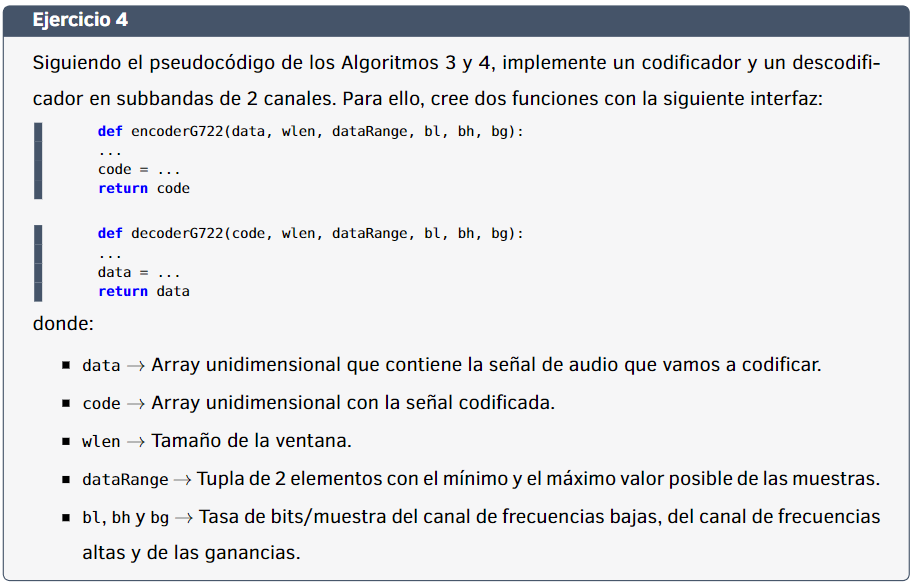

In [8]:

def getBitsPerChannel(nBits, wlen, bLB, bHB, bG):
    bGLB = bG if bLB > 0 else 0 #número de bits que dedicamos a cuantificar la ganancia dentro de cada ventana.
    bGHB = bG if bHB > 0 else 0
    wSize = wlen*(bLB + bHB) + bGLB + bGHB
    nSamples = (nBits // wSize * wlen + max(nBits % wSize - bGLB - bGHB, 0) // (bLB+bHB)) #nos dice cuántas ventanas completas caben en el bit-budget
    nLB = int(nSamples * bLB + np.ceil(nSamples / wlen) * bGLB) #redondear hacia arriba 
    nHB = nBits - nLB
    return nLB, nHB


def encoderG722(data, wlen, dataRange, bl, bh, bg):
    h1 = sc.getG722lpf() # Recupera los coeficientes almacenados del filtro paso-baja
    # Genera el FIR de paso alto por signo alternante, vectorizado
    signs = (-1) ** np.arange(len(h1)) # Calcula el filtro paso-alta como el espejo del filtro paso-baja
    h2 = h1 * signs
    sl = np.convolve(data, h1) #Filtra s con el filtro h1 para obtener el canal de frecuencias bajas
    sh = np.convolve(data, h2)   # Filtra s con el filtro h2 para obtener el canal de frecuencias altas
    # Al usar mode='same', la convolución devuelve una señal de la misma longitud que la señal de entrada original, manteniendo el mismo número de muestras. 
    
    # Reducir la frecuencia de muestreo de las subbandas a la mitad
    sl = sc.downsample(sl, 2) # nos saltamos las impares
    sh = sc.downsample(sh, 2)
    
    # Codificar las subbandas utilizando el algoritmo APCM
    cl = encoderAPCM(sl, wlen, dataRange, bl, bg) if bl > 0 else np.array([], dtype=int) # Codifica el canal de frecuencias bajas con APCM
    ch = encoderAPCM(sh, wlen, dataRange, bh, bg) if bh > 0 else np.array([], dtype=int) ## Codifica el canal de frecuencias altas con APCM

   
    # Concatenar los códigos de las subbandas (canales)
    code = np.concatenate((cl, ch))
   
    return code


def decoderG722(code, wlen, dataRange, bl, bh, bg):
   

    # Filtros de síntesis
    h1 = sc.getG722lpf()
    k1 = 2 * h1
    n = np.arange(len(h1))
    k2 = (-1) ** (n + 1) * k1
    nLB, nHB = getBitsPerChannel(len(code), wlen, bl, bh, bg)  # Num bits correspondiente a cada canal
    
    
    cl = code[:nLB]  # Bits correspondientes al canal de frec. bajas
    ch = code[nLB:nLB + nHB]  # Bits correspondientes al canal de frec. altas

    # Decodificar los bits de cada canal utilizando el algoritmo APCM
    sl = decoderAPCM(cl, wlen, dataRange, bl, bg) if bl > 0 else np.array([], dtype=int) # Decodifica ek canal de frecuencias bajas con APCM
    sh = decoderAPCM(ch, wlen, dataRange, bh, bg) if bh > 0 else np.array([], dtype=int) # Decodifica ek canal de frecuencias altas con APCM

    sl = sc.upsample(sl, 2)    # Intercalar ceros para duplicar la frecuencia de muestreo del canal de frecuencis bajas
    sh =  sc.upsample(sh, 2)   # Intercalar ceros para duplicar la frecuencia de muestreo del canal de frecuencis altas
    
        
    sl_filtrada = np.convolve(sl, k1) if bl > 0 else np.array([], dtype=int) # filtra el canal de frec. bajas con el filtro k1
    sh_filtrada = np.convolve(sh, k2) if bh > 0 else np.array([], dtype=int) # filtra el canal de frec. altas con el filtro k2

    # Garantizamos que, justo antes de sumar ambas ramas, las dos señales tengan exactamente la misma longitud. 
    #( Si no, da error, en algún momento se habrán descompensado las muestras a pesar de hacee la convolución con el same)
    if bl != 0 and bh != 0:
        min_len = min(len(sl_filtrada), len(sh_filtrada)) 
        sl_filtrada = sl_filtrada[:min_len]
        sh_filtrada = sh_filtrada[:min_len]
        data = sl_filtrada + sh_filtrada # Combinar los dos canales para obtener la señal completa
    elif bl != 0:
    # Solo canal bajo existe
        data = sl_filtrada

    elif bh != 0:
    # Solo canal alto existe
        data = sh_filtrada
        

    return data

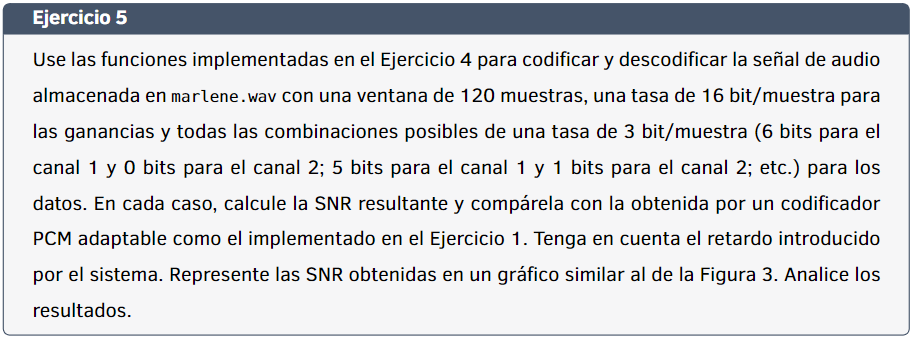

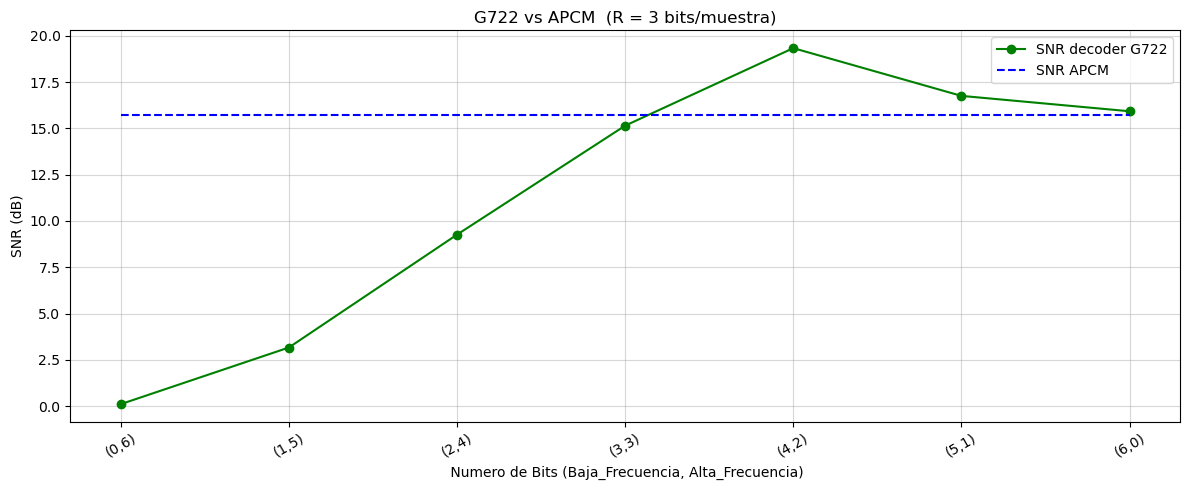

In [10]:

#Parámetros
wlen = 120 # longitud ventana
bg = 16 # tasa bits/muestra para las ganancias


SNRs=[]
delay = 23 # muestras

for b in range(0,6+1):
    code = encoderG722(s, wlen, dataRange, b, 6 - b, bg)
    data = decoderG722(code, wlen, dataRange, b, 6 - b, bg)
    
    # Compensar el retardo
    data_delay = data[delay:] # eliminas esas muestras iniciales “vacías” o desplazadas.
    if len(data_delay) < len(s): # Si al quitar el retraso la señal reconstruida es más corta que la original (len(data_delay) < len(s)), rellenas el final con ceros para que ambas tengan la misma longitud antes de medir SNR.
       data_delay = np.pad(data_delay, (0, len(s) - len(data_delay)))
    else:
       data_delay = data_delay[: len(s)] # en este caso si es mas larga se recorta


    SNRs.append(sc.snr(s,data_delay))  
    
n = len(SNRs)    
b = 3 # bits/muestra
code_apcm = encoderAPCM(s, wlen, dataRange, b, bg)
data_apcm = decoderAPCM(code_apcm, wlen, dataRange, b, bg)
snr_apcm = sc.snr(s, data_apcm)
snr_apcm = np.full(n, snr_apcm)


x = np.arange(n)                     
bit_labels = ['(0,6)','(1,5)','(2,4)','(3,3)','(4,2)','(5,1)','(6,0)']

plt.figure(figsize=(12,5))
plt.plot(x, SNRs, 'go-', label='SNR decoder G722')
plt.plot(x, snr_apcm, 'b--', label='SNR APCM')

# Aquí es donde asignas tus etiquetas de cadena
plt.xticks(x, bit_labels, rotation=30)

plt.title('G722 vs APCM  (R = 3 bits/muestra)')
plt.xlabel(' Numero de Bits (Baja_Frecuencia, Alta_Frecuencia)')
plt.ylabel('SNR (dB)')
plt.grid(alpha=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()